In [133]:
%load_ext autoreload
%autoreload 2
import pickle
import open3d as o3d
import numpy as np
test = None
with open("src/no_ground_all.pkl", "rb") as f:
    test = pickle.load(f)
pkl_downpcd = o3d.geometry.PointCloud()
pkl_downpcd.points = o3d.utility.Vector3dVector(test)

# eps= 3.0
# min_points = 3
eps= 2.5
min_points = 10
print(eps, min_points)

with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(
        pkl_downpcd.cluster_dbscan(eps=eps, min_points=min_points, print_progress=True))

max_label = labels.max()
test.shape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2.5 10
[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2848


(1037625, 3)

In [134]:
def display_labelled_data_2d(data, labels):
    import plotly.graph_objects as go
    from PIL import Image
    small_img = Image.open("../lidar/data/481E_5456N_tiny.png")

    size = 1000
    fig = go.Figure()
    for i in np.arange(labels.max()):
        x_cluster = data[:, 0][np.where(labels == i)]
        y_cluster = data[:, 1][np.where(labels == i)]
        fig.add_trace(go.Scattergl(x=x_cluster, y=y_cluster,
                                    mode='markers',
                                    marker=dict(
                                        size=2,
                                        color=i,                # set color to an array/list of desired values
                                        colorscale='Viridis',   # choose a colorscale
                                        opacity=0.8
    )))
    
    offset = 1000
    fig.add_layout_image(
            dict(
                source=small_img,
                xref="x",
                yref="y",
                x=0,
                y=offset,
                sizex=size,
                sizey=size,
                sizing="stretch",
                opacity=0.8,
                layer="below")
    )

    # Set templates
    fig.update_layout(template="plotly_white")
    fig.update_yaxes(
        scaleanchor = "x",
        scaleratio = 1,
      )
    fig.show()
import plotly.io as pio
# too many points, cannot render embedded
pio.renderers.default = "browser"


display_labelled_data_2d(np.asarray(pkl_downpcd.points), labels)

In [138]:
from PIL import Image
import math
import plotly.graph_objects as go
small_img = Image.open("../lidar/data/481E_5456N_tiny.png")

data = np.asarray(pkl_downpcd.points)
img = np.array(small_img)
print(small_img.mode)
size = 1000
fig = go.Figure()
for i in np.arange(labels.max()):
#     i = labels.max() - i
    x_cluster = data[:, 0][np.where(labels == i)]
    y_cluster = data[:, 1][np.where(labels == i)]
    rgbvi_sum = 0
    gli_sum = 0
    for i in np.arange(x_cluster.shape[0]):
        rgb = img[math.floor(999 - y_cluster[i]), math.ceil(x_cluster[i]) - 1,  :]
        # the default type is uint
        rgb = rgb.astype('float64') 
        gli_sum += (2 * rgb[1] - rgb[0] - rgb[2]) / (2 * rgb[1] + rgb[0] + rgb[2])
        rgbvi_sum +=((rgb[1] * rgb[1] - rgb[0]*rgb[2]) * 1.0) /(rgb[1] * rgb[1]  + rgb[0]*rgb[2]) 
    rgbvi_avg = rgbvi_sum /  x_cluster.shape[0]
    gli_avg = gli_sum /  x_cluster.shape[0]
    # filter
    if rgbvi_avg > 0.03:
#     fig.add_annotation(x=x_cluster[0], y=y_cluster[0],
#         text="rgbvi:%.3f" % rgbvi_avg,
#         showarrow=True,
#         arrowhead=1)
#     fig.add_annotation(x=x_cluster[-1], y=y_cluster[-1],
#         text="gli:%.3f" % gli_avg,
#         showarrow=True,
#         arrowhead=1)
        fig.add_trace(go.Scattergl(x=x_cluster, y=y_cluster, 
           mode = "markers",
            marker=dict(
                size=3,
                color=i,                # set color to an array/list of desired values
                colorscale='Viridis',   # choose a colorscale
                opacity=0.8
        )))

offset = 1000
fig.add_layout_image(
        dict(
            source=small_img,
            xref="x",
            yref="y",
            x=0,
            y=offset,
            sizex=size,
            sizey=size,
            sizing="stretch",
            opacity=0.85,
            layer="below")
)

# Set templates
fig.update_layout(template="plotly_white")
fig.update_traces(textposition='top center')
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )
pio.renderers.default = "jupyterlab"
fig.show()

RGB


<ipython-input-138-5b8cdf0b170b>:22: RuntimeWarning:

invalid value encountered in double_scalars



/home/yiyi/miniconda3/envs/lidar-raw/lib/python3.8/site-packages/PIL/Image.py:2834: DecompressionBombWarning:

Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.



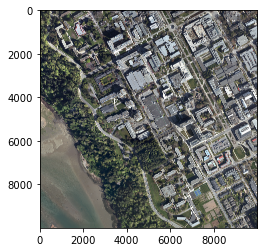

In [69]:

import matplotlib.pyplot as plt

small_img = Image.open("../lidar/data/481E_5456N_small.png")

img = np.array(small_img)

plt.imshow(img)

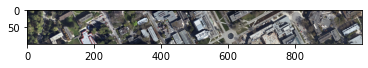

In [36]:
plt.imshow(img[0:100, :, :])